## Using RNNs to classify sentiment on IMDB data

In this project, we will train three types of RNNs:  "vanilla" RNN, LSTM and GRU to predict the sentiment on IMDB reviews.  

Keras provides a convenient interface to load the data and immediately encode the words into integers (based on the most common words). 
This will save you a lot of the drudgery that is usually involved when working with raw text.

The IMDB is  data consists of 25000 training sequences and 25000 test sequences. 
The outcome is binary (positive/negative) and both outcomes are equally represented in both the training and the test set.


Walk through the following steps to prepare the data and the building of an RNN model. 

# Import libraries

In [ ]:
import tensorflow
import keras
from keras.datasets import imdb
from keras.preprocessing import sequence
from tensorflow.keras import optimizers
from keras import initializers
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN
import matplotlib.pyplot as plt
from keras.layers import LSTM
import timeit
from keras.layers.recurrent import GRU
from numpy.random import seed

seed(32)

# Load Data

1- Use the `imdb.load_data()` to load in the data 

2- Specify the maximum length of a sequence to 20000 words and the pick the most common words to 30. 

In [ ]:
vocabulary_size = 20000
max_length = 30
#load the data
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words = vocabulary_size)
print('Loaded dataset with {} training samples, {} test samples'.format(len(X_train), len(X_test)))

3- Check that the number of sequences in train and test datasets are equal (default split):
    
Expected output:
- `x_train = 25000 train sequences`

- `x_test = 25000 test sequences`

In [ ]:
print('---X_train---')
print(len(X_train))
print('---y_train---')
print(len(y_train))
print('---X_test---')
print(len(X_test))
print('---y_test---')
print(len(y_test))
if(len(X_train) == len(X_test)):
    print("Default split: length of test and train is the same:" + str(len(X_train)))

# Pad the sequences

Pad (or truncate) the sequences so that they are of the maximum length
After padding or truncating, check the dimensionality of x_train and x_test.

Expected output:
- `x_train shape: (25000, 30)`
- `x_test shape: (25000, 30)`

In [ ]:
X_train = sequence.pad_sequences(X_train, maxlen= max_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_length)
print('---X_train---')
print(X_train.shape)
print('---X_test---')
print(X_test.shape)
print('---Y_train---')
print(y_train.shape)
print('---y_train---')
print(y_test.shape)

## Keras layers for (Vanilla) RNNs

In this step, you will not use pre-trained word vectors, Instead you will learn an embedding as part of the  the Vanilla) RNNs network  Neural Network. 

In the Keras API documentation, the Embedding Layer and the SimpleRNN Layer have the following syntax:

### Embedding Layer
`keras.layers.embeddings.Embedding(input_dim, output_dim, embeddings_initializer='uniform', embeddings_regularizer=None, activity_regularizer=None, embeddings_constraint=None, mask_zero=False, input_length=None)`

- This layer maps each integer into a distinct (dense) word vector of length `output_dim`.
- Can think of this as learning a word vector embedding "on the fly" rather than using an existing mapping (like GloVe)
- The `input_dim` should be the size of the vocabulary.
- The `input_length` specifies the length of the sequences that the network expects.

### SimpleRNN Layer
`keras.layers.recurrent.SimpleRNN(units, activation='tanh', use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros', kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0, recurrent_dropout=0.0)`

- This is the basic RNN, where the output is also fed back as the "hidden state" to the next iteration.
- The parameter `units` gives the dimensionality of the output (and therefore the hidden state).  Note that typically there will be another layer after the RNN mapping the (RNN) output to the network output.  So we should think of this value as the desired dimensionality of the hidden state and not necessarily the desired output of the network.
- Recall that there are two sets of weights, one for the "recurrent" phase and the other for the "kernel" phase.  These can be configured separately in terms of their initialization, regularization, etc.






Build the RNN with three layers: 
- The SimpleRNN layer with 5 neurons and initialize its kernel with stddev=0.001

- The Embedding layer and initialize it by setting the word embedding dimension to 50. This means that this layer takes each integer in the sequence and embeds it in a 50-dimensional vector.

-  The output layer has the sigmoid activation function.

In [ ]:
embedding_dimension = 50
stddev=0.001
n_count = 5
n_epochs = 10
n_batch_size = 32
learning_rate = .0001
validation_split = 0.2

#function to create vanilla RNN model with three layers
def MyModel(vocabulary_size, embedding_dimension, max_length,n_count, stddev):
    model = Sequential()
    model.add(Embedding(vocabulary_size, embedding_dimension,
                        embeddings_initializer='uniform', 
                        embeddings_regularizer=None, activity_regularizer=None, 
                        embeddings_constraint=None, 
                        mask_zero=False, input_length=max_length))
    #SimpleRNN with stddev = 0.001
    model.add(SimpleRNN(n_count,
                        kernel_initializer= keras.initializers.random_normal(stddev=stddev)))

    #The output layer has the sigmoid activation function.
    model.add(Dense(1, activation='sigmoid'))
    return model
model_30 = MyModel(vocabulary_size, embedding_dimension, max_length, n_count, stddev)
model_30.summary()    

Train the network with the RMSprop with learning rate of .0001 and epochs=10. PLot the loss and accuracy metrics during the training and interpret the result.

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
def FitAndPlot(model, early_stop = False):
    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
    if (early_stop == False):
      history = model.fit(X_train, y_train,
                          epochs=n_epochs,
                          batch_size=n_batch_size,
                          validation_split= 0.2
                          ) 
    elif early_stop == True:
      history = model.fit(X_train, y_train,
                          epochs=n_epochs,
                          batch_size=n_batch_size,
                          validation_split= 0.2,
                          callbacks=[es])

    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

Check the accuracy and the loss of your models on the test dataset.

In [ ]:
model_30.compile(optimizer = tensorflow.keras.optimizers.RMSprop(
             learning_rate=learning_rate),
              loss='binary_crossentropy', 
              metrics=['acc'])
print("batch size : " + str(n_batch_size))
print("epochs : " + str(n_epochs))
FitAndPlot(model_30)

In [ ]:
model_30.evaluate(X_test,y_test)

Validation accuracy saturates although training accuracy increases. So there is an overfitting problem as the model fails to generalize on unseen data. Also early stopping can be employed in this case.
Note : In different runs, the accuracy values are different in spite of setting the seed.

## Tuning The Vanilla RNN Network


11- Prepare the data to use sequences of length 80 rather than length 30 and retrain your model.  Did it improve the performance?

12- Try different values of the  maximum length of a sequence ("max_features").  Can you improve the performance?

13- Try smaller and larger sizes of the RNN hidden dimension.  How does it affect the model performance?  How does it affect the run time?

In [ ]:
#load the data
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words = vocabulary_size)
print('Loaded dataset with {} training samples, {} test samples'.format(len(X_train), len(X_test)))

max_length = 80
X_train = sequence.pad_sequences(X_train, maxlen= max_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_length)
print('---X_train---')
print(X_train.shape)
print('---X_test---')
print(X_test.shape)

In [ ]:
model_80 = MyModel(vocabulary_size, embedding_dimension, max_length, n_count, stddev)
model_80.summary()

model_80.compile(optimizer = tensorflow.keras.optimizers.RMSprop(
             learning_rate=learning_rate),
              loss='binary_crossentropy', 
              metrics=['acc'])

print("batch size : " + str(n_batch_size))
print("epochs : " + str(n_epochs))
FitAndPlot(model_80)

In [ ]:
model_80.evaluate(X_test,y_test)

The Accuracy of the model both train and test increased as we fed more data to train the model. However, it might always be the case as RNN models fails to remember the longer sentences as they don't have memory.
Let us try other values for the a max length.


In [ ]:
#load the data
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words = vocabulary_size)
print('Loaded dataset with {} training samples, {} test samples'.format(len(X_train), len(X_test)))

max_length = 92
n_count = 64
stddev=0.0001

X_train = sequence.pad_sequences(X_train, maxlen= max_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_length)
print('---X_train---')
print(X_train.shape)
print('---X_test---')
print(X_test.shape)

model_x = MyModel(vocabulary_size, embedding_dimension, max_length, n_count, stddev)
model_x.summary()

batch size : 32
epochs : 10
Epoch 1/10
625/625 [==============================] - 18s 27ms/step - loss: 0.6915 - acc: 0.5226 - val_loss: 0.6791 - val_acc: 0.5682
Epoch 2/10
625/625 [==============================] - 17s 27ms/step - loss: 0.6558 - acc: 0.6191 - val_loss: 0.6446 - val_acc: 0.6392
Epoch 3/10
625/625 [==============================] - 17s 26ms/step - loss: 0.6054 - acc: 0.6819 - val_loss: 0.6228 - val_acc: 0.6606
Epoch 4/10
625/625 [==============================] - 17s 27ms/step - loss: 0.5674 - acc: 0.7187 - val_loss: 0.6106 - val_acc: 0.6712
Epoch 5/10
625/625 [==============================] - 18s 29ms/step - loss: 0.5331 - acc: 0.7438 - val_loss: 0.6184 - val_acc: 0.6750
Epoch 6/10
625/625 [==============================] - 18s 29ms/step - loss: 0.4988 - acc: 0.7653 - val_loss: 0.6064 - val_acc: 0.6748
Epoch 7/10
625/625 [==============================] - 18s 29ms/step - loss: 0.4708 - acc: 0.7844 - val_loss: 0.6172 - val_acc: 0.6734
Epoch 8/10
625/625 [==============

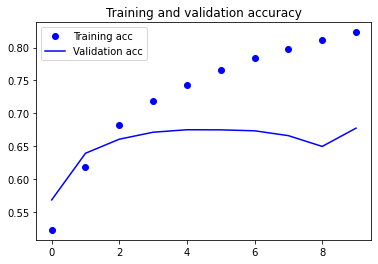

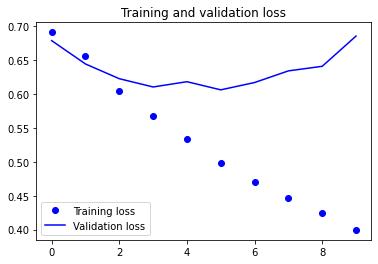

In [38]:
model_x.compile(optimizer = tensorflow.keras.optimizers.RMSprop(
             learning_rate=learning_rate),
              loss='binary_crossentropy', 
              metrics=['acc'])
print("batch size : " + str(n_batch_size))
print("epochs : " + str(n_epochs))
FitAndPlot(model_x) 

Tried increasing the number of nuerons in the hidden layer from 64 to 128. It only increased the number of parameter and not the accuracy. It is also observed that after some epochs, the validation accuracy saturates so it would be good idea to early stop to avert excessive usage of compute resources.

Also, tried the 

In [39]:
model_x.evaluate(X_test,y_test)

782/782 [==============================] - 6s 8ms/step - loss: 0.7117 - acc: 0.6638


[0.7116975784301758, 0.6638399958610535]

## Train LSTM and GRU networks
GRU (Gated Recurrent Unit) aims to solve the vanishing gradient problem which comes with a standard recurrent neural network. GRU can also be considered as a variation on the LSTM because both are designed similarly and, in some cases, produce equally excellent results.


Build LSTM and GRU networks and compare their performance (accuracy and execution time) with the SimpleRNN. What is your conclusion?

In [40]:
def build_model_lstm(max_features,embedding_dim, maxlen, n_count, reg):
  model = Sequential()
  model.add(Embedding(max_features,embedding_dim, input_length=maxlen))
  model.add(LSTM(n_count,dropout=reg))
  model.add(Dense(1, activation='sigmoid'))
  return model
reg = 0.5  
lstm = build_model_lstm(vocabulary_size, embedding_dimension, max_length, n_count, reg)
lstm.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 92, 50)            1000000   
                                                                 
 lstm_1 (LSTM)               (None, 64)                29440     
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 1,029,505
Trainable params: 1,029,505
Non-trainable params: 0
_________________________________________________________________


batch size : 32
epochs : 10
Epoch 1/10
625/625 [==============================] - 44s 67ms/step - loss: 0.6804 - acc: 0.5717 - val_loss: 0.6031 - val_acc: 0.6744
Epoch 2/10
625/625 [==============================] - 47s 75ms/step - loss: 0.5445 - acc: 0.7271 - val_loss: 0.4632 - val_acc: 0.7818
Epoch 3/10
625/625 [==============================] - 43s 69ms/step - loss: 0.4310 - acc: 0.8072 - val_loss: 0.4367 - val_acc: 0.8012
Epoch 4/10
625/625 [==============================] - 40s 64ms/step - loss: 0.3808 - acc: 0.8338 - val_loss: 0.3748 - val_acc: 0.8318
Epoch 5/10
625/625 [==============================] - 42s 67ms/step - loss: 0.3452 - acc: 0.8518 - val_loss: 0.3601 - val_acc: 0.8416
Epoch 6/10
625/625 [==============================] - 40s 64ms/step - loss: 0.3233 - acc: 0.8634 - val_loss: 0.3493 - val_acc: 0.8454
Epoch 7/10
625/625 [==============================] - 42s 67ms/step - loss: 0.3036 - acc: 0.8740 - val_loss: 0.3441 - val_acc: 0.8478
Epoch 8/10
625/625 [==============

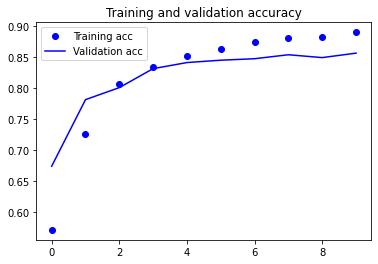

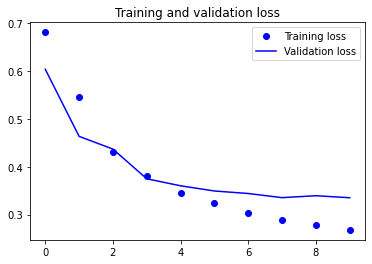

In [18]:
lstm.compile(optimizer = tensorflow.keras.optimizers.RMSprop(
             learning_rate=learning_rate),
              loss='binary_crossentropy', 
              metrics=['acc'])

print("batch size : " + str(n_batch_size))
print("epochs : " + str(n_epochs))
FitAndPlot(lstm)

In [19]:
lstm.evaluate(X_test,y_test)

782/782 [==============================] - 13s 17ms/step - loss: 0.3375 - acc: 0.8512


[0.3374865651130676, 0.8511599898338318]

In [20]:
def build_model_gru(max_features,embedding_dim, maxlen, n_count, reg):
  model = Sequential()
  model.add(Embedding(max_features,embedding_dim, input_length=maxlen))
  model.add(GRU(n_count, dropout=reg))
  model.add(Dense(1, activation='sigmoid'))
  return model

reg = 0.5
model_gru = build_model_gru(vocabulary_size, embedding_dimension, max_length, n_count, reg)  
model_gru.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 92, 50)            1000000   
                                                                 
 gru (GRU)                   (None, 64)                22080     
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,022,145
Trainable params: 1,022,145
Non-trainable params: 0
_________________________________________________________________


batch size : 32
epochs : 10
Epoch 1/10
625/625 [==============================] - 66s 102ms/step - loss: 0.6906 - acc: 0.5480 - val_loss: 0.6855 - val_acc: 0.6098
Epoch 2/10
625/625 [==============================] - 63s 101ms/step - loss: 0.5899 - acc: 0.6942 - val_loss: 0.4918 - val_acc: 0.7700
Epoch 3/10
625/625 [==============================] - 64s 103ms/step - loss: 0.4438 - acc: 0.7929 - val_loss: 0.4027 - val_acc: 0.8174
Epoch 4/10
625/625 [==============================] - 64s 103ms/step - loss: 0.3758 - acc: 0.8347 - val_loss: 0.3678 - val_acc: 0.8304
Epoch 5/10
625/625 [==============================] - 64s 103ms/step - loss: 0.3404 - acc: 0.8492 - val_loss: 0.3523 - val_acc: 0.8416
Epoch 6/10
625/625 [==============================] - 66s 106ms/step - loss: 0.3172 - acc: 0.8633 - val_loss: 0.3428 - val_acc: 0.8456
Epoch 7/10
625/625 [==============================] - 64s 103ms/step - loss: 0.3005 - acc: 0.8706 - val_loss: 0.3466 - val_acc: 0.8492
Epoch 8/10
625/625 [=======

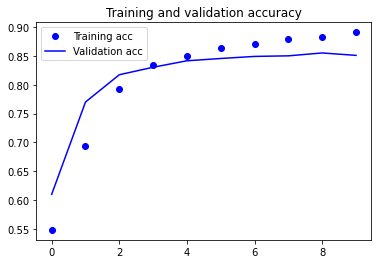

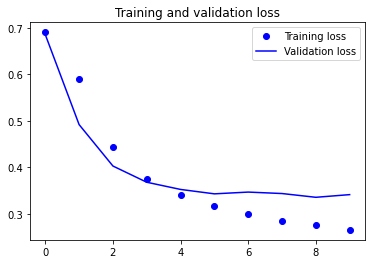

In [21]:
model_gru.compile(optimizer = tensorflow.keras.optimizers.RMSprop(
             learning_rate=learning_rate),
              loss='binary_crossentropy', 
              metrics=['acc'])

print("batch size : " + str(n_batch_size))
print("epochs : " + str(n_epochs))
FitAndPlot(model_gru)

In [22]:
model_gru.evaluate(X_test,y_test)

782/782 [==============================] - 13s 17ms/step - loss: 0.3371 - acc: 0.8526


[0.3370715379714966, 0.8525599837303162]

In [23]:
def build_model_gru1(max_features,embedding_dim, maxlen, n_count1, n_count2, reg):
  model = Sequential()
  model.add(Embedding(max_features,embedding_dim, input_length=maxlen))
  model.add(GRU(n_count1, dropout=reg, recurrent_dropout=reg))
  model.add(Dense(n_count2, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  return model

reg = 0.5
n_count1 = 32
n_count2 = 32
model_gru_2 = build_model_gru1(vocabulary_size, embedding_dimension, max_length, n_count1, n_count2, reg)  
model_gru_2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 92, 50)            1000000   
                                                                 
 gru_1 (GRU)                 (None, 32)                7968      
                                                                 
 dense_5 (Dense)             (None, 32)                1056      
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,009,057
Trainable params: 1,009,057
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_gru_2.compile(optimizer = tensorflow.keras.optimizers.RMSprop(
             learning_rate=learning_rate),
              loss='binary_crossentropy', 
              metrics=['acc'])

print("batch size : " + str(n_batch_size))
print("epochs : " + str(n_epochs))
FitAndPlot(model_gru_2)

batch size : 32
epochs : 10
Epoch 1/10
625/625 [==============================] - 55s 84ms/step - loss: 0.6919 - acc: 0.5261 - val_loss: 0.6887 - val_acc: 0.5856
Epoch 2/10
396/625 [==================>...........] - ETA: 18s - loss: 0.6837 - acc: 0.5934

In [ ]:
model_gru_2.evaluate(X_test,y_test)

Summarizing:

#Model with max length 30: 
train:
Epoch 10/10
625/625 [==============================] - 7s 11ms/step - loss: 0.5380 - acc: 0.7391 - val_loss: 0.7002 - val_acc: 0.5886
test:
782/782 [==============================] - 2s 3ms/step - loss: 0.7028 - acc: 0.5892
[0.7028330564498901, 0.5891600251197815]


#Model with max length 80:
train:
Epoch 10/10
625/625 [==============================] - 13s 21ms/step - loss: 0.4281 - acc: 0.8542 - val_loss: 0.4736 - val_acc: 0.8010
test:
782/782 [==============================] - 4s 6ms/step - loss: 0.4894 - acc: 0.7839
[0.4894128441810608, 0.7839199900627136]

#Model with max length 92 and increased nueron count in hidden layer = 64:
train:
Epoch 10/10
625/625 [==============================] - 17s 28ms/step - loss: 0.2240 - acc: 0.9143 - val_loss: 0.4490 - val_acc: 0.8196
test:
782/782 [==============================] - 6s 7ms/step - loss: 0.4554 - acc: 0.8172
[0.4553954303264618, 0.8171600103378296]

Test and Train Accuracy of the model increased by increasing the max length to 80. Accuracy further increased on increasing the max length to 92. Upon trying multiple runs, the outcome is not consistent. Overall RNN networks are fluctating for sentences of longer length and RNN might not be a suitable model for inputs with longer length.

#LSTM networks with increased number of neurons = 64 
train:
Epoch 10/10
625/625 [==============================] - 36s 58ms/step - loss: 0.2677 - acc: 0.8885 - val_loss: 0.3309 - val_acc: 0.8526

seems to be doing a good job on both test and train
test:
782/782 [==============================] - 11s 14ms/step - loss: 0.3294 - acc: 0.8534
[0.3293779790401459, 0.8533999919891357]

#GRU network 
train:
Epoch 10/10
625/625 [==============================] - 60s 95ms/step - loss: 0.2711 - acc: 0.8876 - val_loss: 0.3313 - val_acc: 0.8570

782/782 [==============================] - 12s 15ms/step - loss: 0.3302 - acc: 0.8559
[0.3301633298397064, 0.8559200167655945]

with increased number of neurons = 64 seems to be doing a good job on both test and train.

# GRU network with dense layer
Upon introdcing an extra dense layer with 32 nuerons, GRU networks gave a better performance.
train:
Epoch 10/10
625/625 [==============================] - 47s 76ms/step - loss: 0.3145 - acc: 0.8726 - val_loss: 0.3394 - val_acc: 0.8526

782/782 [==============================] - 10s 12ms/step - loss: 0.3380 - acc: 0.8530
[0.3379809856414795, 0.8529999852180481]